# Electromagnetic scattering from flat screens

### Background

In this tutorial, we consider the scattering of an electromagnetic wave from a collection of perfectly conducting screens. The time-harmonic Maxwell equation for the electric field $\mathbf{E}$ reduces to

$$
\nabla\times\nabla\times \mathbf{E} -k^2 \mathbf{E} = 0
$$

in $\mathbb{R}^3\backslash\Gamma$, where $k:=2\pi/\lambda$ is the wavenumber, $\lambda$ is the wavelength, and $\Gamma$ denotes the screens. The electric field $\mathbf{E}$ is the sum of the incident field $\mathbf{E}^\text{inc}$ and the scattered field $\mathbf{E}^\text{s}$. Here, we use the incident field given by

$$
\mathbf{E}^\text{inc}(\mathbf{x}):=\begin{bmatrix} \mathrm{e}^{\mathrm{i}kz} & 0 & 0 \end{bmatrix},
$$

which is a wave travelling in the $z$ direction and polarised in the $x$ direction. On the screen, the tangential component $\mathbf{E}_\text{t}:=\nu\times \mathbf{E}$ must be zero. Towards infinity we impose the Silver&ndash;M&uuml;ller radiation condition

$$
\lim_{|\mathbf{x}|\rightarrow\infty} |\mathbf{x}|\left(\nabla\times \mathbf{E}^\text{s}\times\frac{\mathbf{x}}{|\mathbf{x}|}-\mathrm{i}k\mathbf{E}^\text{s}\right) = 0,
$$
where $\hat{\mathbf{x}}=\mathbf{x}/|\mathbf{x}|$.

The scattered wave $\mathbf{E}^\text{s}$ has the representation

$$
\mathbf{E}^\text{s} = -\mathcal{E}\Lambda,
$$

where $\Lambda$ is the jump of the Neumann trace of the scattered field $\mathbf{E}^\text{s}$ across the screen. The <a href='https://bempp.com/2017/07/11/available_operators/'>Maxwell electric field potential operator</a> $\mathcal{E}$ is defined as

$$
\mathcal{E}(\mathbf{v}):=\mathrm{i}k\int_{\Gamma}g(\mathbf{x},\mathbf{y})\mathbf{v}(\mathbf{y})\mathrm{d}\mathbf{y}-
\frac1{\mathrm{i}k}\nabla_{\mathbf{x}}\int_{\Gamma}g(\mathbf{x},\mathbf{y})(\nabla_{\Gamma}\cdot\mathbf{v})(\mathbf{y})\mathrm{d}\mathbf{y}
$$
with $g(\mathbf{x},\mathbf{y}):=\frac{\mathrm{e}^{\mathrm{i}k|\mathbf{x}-\mathbf{y}|}}{4\pi|\mathbf{x}-\mathbf{y}|}$.

The associated boundary operator is denoted by $\mathsf{E}$. It is defined as average tangential trace of the electric field potential operator from both sides of the screen. The boundary integral equation is now

$$
\mathsf{E}\Lambda = \nu\times \mathbf{E}^\text{inc}.
$$
The $-$ sign is missing in comparison to the representation formula since we want to satisfy the boundary conditions for the negative incident wave so that the tangential trace of the total field is zero on the screen.

More details about the mathematical background can be found in <a href='http://www.sam.math.ethz.ch/~hiptmair/Courses/CEM/BUH03.pdf' target='new'>Buffa & Hiptmair (2003)</a>.

### Implementation

We start with the usual imports.

In [1]:
import bempp.api
import numpy as np
import numba

We next define the wavenumber of the problem.

In [2]:
wavelength = 1
k = 2 * np.pi / wavelength

We define the grid to be the union of three screens.

In [3]:
corners1 = np.array([[-.5, -1, 0],
                     [-.5, 1, 0],
                     [-2, 1, 2],
                     [-2, -1, 2]])
corners2 = np.array([[.5, -1, 0],
                     [.5, 1, 0],
                     [2, 1, 2],
                     [2, -1, 2]])
corners3 = np.array([[-1, -1, -1],
                    [1, -1, -1],
                    [1, 1, -1],
                    [-1, 1, -1]])


grid1 = bempp.api.shapes.screen(corners1)
grid2 = bempp.api.shapes.screen(corners2)
grid3 = bempp.api.shapes.screen(corners3)
grid = bempp.api.grid.union([grid1, grid2, grid3])


We define the spaces of order 0 RWG div-conforming functions and order 0 scaled N&eacute;d&eacute;lec curl-conforming functions.

In [4]:
div_space = bempp.api.function_space(grid, "RWG", 0)
curl_space = bempp.api.function_space(grid, "SNC", 0)

Next, we define the Maxwell electric field boundary operator and the identity operator. For Maxwell problems, the ``domain`` and ``range`` spaces should be div-conforming, while the ``dual_to_range`` space should be curl conforming.

In [5]:
elec = bempp.api.operators.boundary.maxwell.electric_field(
    div_space, div_space, curl_space, k)
identity = bempp.api.operators.boundary.sparse.identity(
    div_space, div_space, curl_space)

We create a grid function to represent the incident wave. In addition, we define a Python callable with the incident field, which is later used for plotting.

In [6]:
def incident_field(x):
    return np.array([np.exp(1j * k * x[2]), 0. * x[2], 0. * x[2]])

@bempp.api.complex_callable
def tangential_trace(x, n, domain_index, result):
    incident_field = np.array([np.exp(1j * k * x[2]), 0. * x[2], 0. * x[2]])
    result[:] = np.cross(incident_field, n)

trace_fun = bempp.api.GridFunction(div_space, fun=tangential_trace, dual_space=curl_space)

We use a direct LU solver to solve the system.

In [7]:
from bempp.api.linalg import lu
lambda_data = lu(elec, trace_fun)

Now that the solution $\mathbf{\Lambda}$ is computed, we want to plot the total field. First, we define a grid of points in the $x$-$z$ plane.

In [8]:
nx = 300
nz = 300
extent = 3
x, y, z = np.mgrid[-extent:extent:nx * 1j,
                   0:0:1j,
                   -extent:extent:nz * 1j]
points = np.vstack((x.ravel(), y.ravel(), z.ravel()))

We now initialise the electric field potential operator.

In [9]:
slp_pot = bempp.api.operators.potential.maxwell.electric_field(
    div_space, points, k)

The following commands now compute the total field by first computing the scattered field from the representation formula then adding the incident field.

In [10]:
scattered_field_data = -slp_pot * lambda_data
incident_field_data = incident_field(points)
field_data = scattered_field_data + incident_field_data

In electromagnetic scattering it is often useful to visualise the squared electric field density. This value is computed below.

In [11]:
squared_field_density = np.real(np.sum(field_data * field_data.conj(), axis=0))

Finally, we can plot everything using a simple Matplotlib plot.

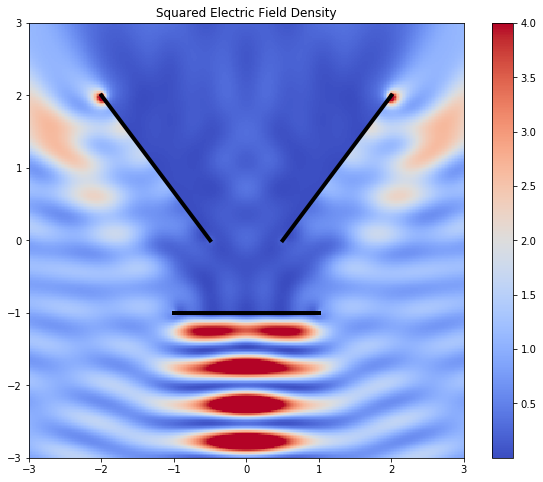

In [12]:
%matplotlib inline
import matplotlib
from matplotlib import pylab as plt
# Adjust the figure size in IPython
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0) 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

im = ax.imshow(squared_field_density.reshape((nx, nz)).T,
               cmap='coolwarm', origin='lower',
               extent=[-extent, extent, -extent, extent], vmax=4)
ax.plot([-.5, -2], [0, 2], 'k-', linewidth=4)
ax.plot([.5, 2], [0, 2], 'k-', linewidth=4)
ax.plot([-1, 1], [-1, -1], 'k-', linewidth=4)


fig.colorbar(im, ax=ax)
_ = ax.set_title("Squared Electric Field Density")